# Building chimeras

We can build chimeras from two proteins that present a fragment in common. There are several ways to do this, but we will here build a chimera by aligning the domains (in the fragment they have in common) and finding a crossover point in this region that divides the two parents in two parts. The parts are then shuffled and recombined. 

First import the protlego module.

In [1]:
from protlego.all import *

/agh/projects/noelia/github/protlego/TMalign


Fetch for example by the HitID from the Fuzzle database, as explained more in detail in the "Fetching from the Fuzzle database" section. We are fetching a hit between the P-loop and the Rossmann folds in this case.

In [2]:
myhit= fetch_id('4413706')

### Chimera-Building using Protlego

First create an instance of the Builder class.

In [3]:
a=Builder(myhit)

2020-10-16 12:17:21,548 - protlego - INFO - Attempting to download domain d2dfda1 from the SCOP server
2020-10-16 12:17:22,721 - protlego - INFO - File downloaded as /tmp/tmp723odzdf.pdb
2020-10-16 12:17:22,721 - protlego - INFO - Attempting to download domain d1wa5a_ from the SCOP server
2020-10-16 12:17:23,881 - protlego - INFO - File downloaded as /tmp/tmpz50rsvv3.pdb
2020-10-16 12:17:23,883 - protlego - INFO - Loading /tmp/tmp723odzdf.pdb as a chimera object
2020-10-16 12:17:23,960 - moleculekit.molecule - WARNING - Alternative atom locations detected. Only altloc A was kept. If you prefer to keep all use the keepaltloc="all" option when reading the file.
2020-10-16 12:17:23,964 - protlego - INFO - Loading /tmp/tmpz50rsvv3.pdb as a chimera object


You can see the query and the subject of the hit stored in the variables qPDB and sPDB as chimera objects

In [4]:
a.qPDB

Protein with:
Number of residues: 145
Number of atoms: 1054

As described in the previous tutorial, myhit includes information about the two proteins that share a fragment, like the scop IDs, length, and TM-align scores,  among others.

In [5]:
print(myhit)
print(myhit.q_scop_id)
print(myhit.s_scop_id)
print(myhit.cols)
print(myhit.score_tm)

Hit between d2dfda1 and d1wa5a_ with probability 81.7 %

c.2.1.5
c.37.1.8
101
0.54938


Align the sequences of query and subject with HHPred using get_alignment function.

In [6]:
aln=a.get_alignment(myhit.query,myhit.no)

2020-10-16 12:17:24,046 - protlego - INFO - Attempting to download hhs file for d2dfda1 from the FUZZLE server
2020-10-16 12:17:24,184 - protlego - INFO - File downloaded as /tmp/tmpg1t9myzv.hhs


Now we can have a look at the sequence alignment:

In [7]:
print(aln.query)
print(aln.subject)

KVAVLGASGGIGQ-PLSLLLKNS------------PLVSRLTLYDIAHTPGVAADLSHIETKAAVKGYLGPEQLPDCLKGCDVVVIPAGVPRKPGMTRDDLFNTNATIVATLTAACAQHCPEAMICVIANPVN
KLVLVG-DGGTGKTTFVKRHLTGEFEKKYVATLGVEVHPLVFHTNRGPIKFNVWDTAGQEKFGGLRDGY--------YIQAQCAIIMFDVTSRV----------TYKNVPNWHRDLVRVCENIPIVLCGNKVD


The sequence alignment corresponds to the exact fragment that the two proteins have in common, so it does not include the full protein sequences. Now, we need to map these alignments to the protein structures, because ultimately we need to align the two protein structures in these fragment region. 

We can thus superimpose the structures with the superimpose_structures() function, and we choose to align the structures using partial alignment. This means that instead of only one, global alignment being produced, rather, several alignments comprising smaller regions of the fragment (10-20 residues) are undertaken in parallel. We do this to provide multiple regions where the two proteins are closer than 1 armstrong in distance, and thus obtain more fusion points for the chimeras.

In [8]:
qPDB, sPDB = a.superimpose_structures(aln,partial_alignment=True)

2020-10-16 12:17:25,126 - protlego - INFO - Performing alignment 1 with TMalign
/agh/projects/noelia/miniconda3/envs/release/lib/python3.6/site-packages/moleculekit/align.py:16: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, A))
  covariance = np.dot(P.T, Q)
/agh/projects/noelia/miniconda3/envs/release/lib/python3.6/site-packages/moleculekit/align.py:54: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, A))
  all1 = np.dot(all1, rot.T)
2020-10-16 12:17:28,332 - protlego - INFO - The RMSD between the fragments is 0.6881077885627747 over 6 alpha carbons
2020-10-16 12:17:28,340 - protlego - INFO - Performing alignment 2 with TMalign
2020-10-16 12:17:28,420 - protlego - INFO - The RMSD between the fragments is 2.323467254638672 over 6 alpha carbons
2020-10-16 12:17:28,430 - protlego - INFO - Performing alignment 3 with TMalign
2020-10-16 12:17:28,498 

The two variables produced are two dictionaries, which contain several molecules, each pair in a geometry that optimizes each of the alignments. We can visualize these structures easily, by simply calling the view() method. A new VMD window will open showing the structure. For example, less visualize the first alignment by slicing the first key in the dictionary:


In [9]:
qPDB[0].view()

The superimpose_structures() command also produces two lists for query and subject. One of them is global_qpairs, which simply contains the indices of the protein that correspond to the srquence aligment. This list is used when we superimpose the structures using a global alignment (all atoms taken into account at once). The other is qpairs, which correspond to the same residues, but they are clustered in smaller regions that will be aligned iteratively if we choose to perform a partial alignment. 

In [10]:
print(a.qpairs)
print(a.global_qpairs)

[[14, 23, 30, 35, 42, 50], [59, 65, 69, 73, 81, 85], [94, 101, 109, 115, 123, 131, 139, 148, 156], [162, 169, 177, 184, 190, 201, 209, 216, 224, 236, 244, 252, 257, 267, 274, 281, 285, 292, 297, 302, 310, 318, 324, 334, 342, 351, 358, 364, 369, 374, 381, 390, 394, 406], [472, 480, 489, 493, 499, 507, 514, 521, 528, 536, 543, 548, 552, 559, 566, 577, 586], [673, 681, 686, 693, 701, 708, 713, 720, 728, 735, 740, 745, 751, 756, 765, 775, 781, 788, 797, 802, 810, 818, 824, 831, 839, 844, 852, 859, 866]]
[[14, 23, 30, 35, 42, 50, 59, 65, 69, 73, 81, 85, 94, 101, 109, 115, 123, 131, 139, 148, 156, 162, 169, 177, 184, 190, 201, 209, 216, 224, 236, 244, 252, 257, 267, 274, 281, 285, 292, 297, 302, 310, 318, 324, 334, 342, 351, 358, 364, 369, 374, 381, 390, 394, 406, 472, 480, 489, 493, 499, 507, 514, 521, 528, 536, 543, 548, 552, 559, 566, 577, 586, 673, 681, 686, 693, 701, 708, 713, 720, 728, 735, 740, 745, 751, 756, 765, 775, 781, 788, 797, 802, 810, 818, 824, 831, 839, 844, 852, 859, 866]]


Now we can build all the possible chimeras and store them in a dictionary.

In [11]:
chimeras=a.build_chimeras(partial_alignment=True)

In [12]:
chimeras

{'comb1_72': <protlego.builder.chimera.Chimera object at 0x7f2f99764f28>
 Protein with:
 Number of residues: 163
 Number of atoms: 1278,
 'comb1_73': <protlego.builder.chimera.Chimera object at 0x7f2f997614e0>
 Protein with:
 Number of residues: 163
 Number of atoms: 1279,
 'comb1_74': <protlego.builder.chimera.Chimera object at 0x7f2f99769c18>
 Protein with:
 Number of residues: 163
 Number of atoms: 1274,
 'comb2_75': <protlego.builder.chimera.Chimera object at 0x7f2f998b8fd0>
 Protein with:
 Number of residues: 152
 Number of atoms: 1166,
 'comb1_76': <protlego.builder.chimera.Chimera object at 0x7f2f9973ffd0>
 Protein with:
 Number of residues: 163
 Number of atoms: 1274,
 'comb2_76': <protlego.builder.chimera.Chimera object at 0x7f2f998c7fd0>
 Protein with:
 Number of residues: 152
 Number of atoms: 1167,
 'comb1_77': <protlego.builder.chimera.Chimera object at 0x7f2f99812fd0>
 Protein with:
 Number of residues: 163
 Number of atoms: 1275,
 'comb1_78': <protlego.builder.chimera.Ch

From the Builder class you can plot all the possible chimeras, showing the distance on the y-axis and the fragment of the query relative to the domain in the subject. There are five possible scenarios. For every two fussion point that is under the cutoff distanc (1 Armstrong in this case) we can build chimeras starting from the N-terminus and C-terminus. When the two resulting chimeras at this point present backbone clashes, the plot shows a black dot at this position. If the N-terminus or C-terminus is chimera is buildable, we show that position with a cross in yellow, and red, respectively. In some fusion points, like position 145 in this example, it is possible to build both N-terminus and C-terminus chimeras. 

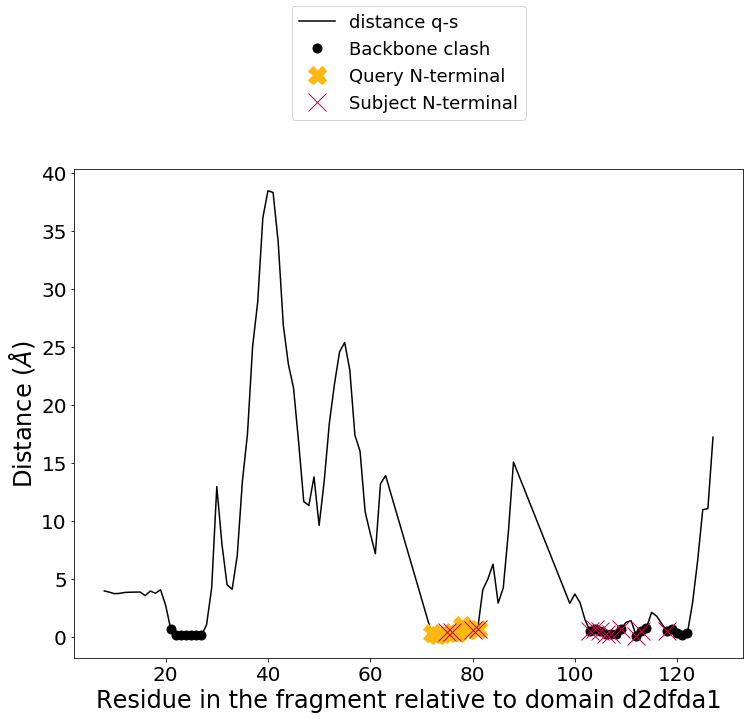

In [13]:
a.plot_curves(myhit.query)

To access the chimeras we can retrieve them from the key value in the dictionary. Combinations starting with 1 come from the query, and combinations starting with 2 come from the subject.

To view or write the structures out you can store the chimera from the chimeras dictionary in a variable and use the view and the write function.

In [14]:
mychimera=chimeras['comb1_72']

In [15]:
mychimera.view()

When we represent the structures we can see the part that comes from each parent is shown in different colors. We can also save the structure as a pdb anytime:

In [16]:
mychimera.write('./mychimera.pdb')

We can, in fact, visualize all of them at once by looping over the structures:

In [17]:
for name, chimera in chimeras.items():
    chimera.view(name=name)

Note that VMD guesses the bonds between atoms by computing distances. As these structures have not been minimized they do not have idealized bond distances and sometimes VMD cannot guess properly the NewCartoon representation. Choose Licorice Method to represent those cases.